# Large field limit
The probability of an individual box to give the right result is $P$. For a field size $n$ the number fo cells is $n^2$. In QSeaBattle we force $n^2$ to be a power of 2. The number of iterations in the pyramid model is $^{2}log(n^2)$. So, for a field of $2\times{x}2$ we have 2 iterations, for a field of $4 \times{x} 4$ we have 4 iterations.

The probability $P$ relates to Pawlossky's $E$ and the CHSH value $K$.
$$
P = \frac{1}{2}(1 + E) \\[0.6cm]
P = \frac{1}{2}(1 + \frac{K}{4})
$$

For a given $P$ the probability to make an even number of mistakes in a sequence of length $n$ is 
$$
P_{even} = \frac{1}{2}\left[1 + (2P-1)^n\right].
$$

In the plot we will plot the 2-log of the 'bias', the probability above the random value of 50%. So, the Y-axis value is:
$$
Y = ^2\log{(P_{even} - \frac{1}{2})} \\[0.6cm]
Y = ^2\log{\frac{1}{2}\left[1 + (2P-1)^n\right] - \frac{1}{2}} \\[0.6cm]
Y = ^2\log{(\frac{1}{2}\cdot(2P-1)^n)} \\[0.6cm]
Y = n\cdot^2\log{(2P-1)} - 1 \\[0.6cm]
$$

if we 'scale' the Y-axis with the size of the field as $Y_{scaled} = Y / n$
$$
Y_{scaled} = \log{(2P-1)} -1 \\[0.6cm]
$$

So, for $P$ equal to 100% $Y_{scaled}$ is always -1. 

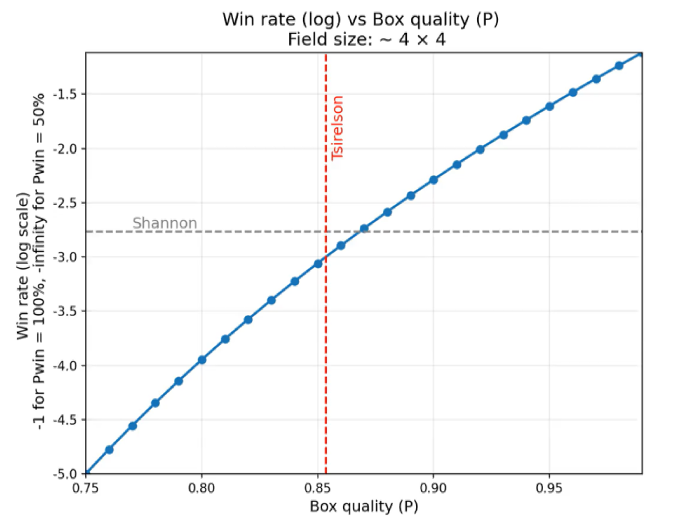

## Probability for even number of mistakes in a sequence
Let $n \in \mathbb{N}$ be the number of independent trials. On each trial, the outcome is

- "right" with probability $P$,
- "wrong" with probability $1-P$.

Let $W$ be the number of "wrong" outcomes among the $n$ trials. Then
$$
W \sim \mathrm{Binomial}(n,\,1-P),
$$
so for any $w \in \{0,1,\dots,n\}$,
$$
\Pr(W=w)=\binom{n}{w}(1-P)^w P^{n-w}.
$$

We want the probability of an even number of mistakes:
$$
\Pr(W\ \text{even})=\sum_{j=0}^{\lfloor n/2 \rfloor} \Pr(W=2j)
=\sum_{j=0}^{\lfloor n/2 \rfloor} \binom{n}{2j}(1-P)^{2j}P^{n-2j}.
\tag{1}
$$

To obtain a closed form, consider the binomial expansions
$$
(P+(1-P))^n=\sum_{w=0}^n \binom{n}{w} P^{n-w}(1-P)^w,
\tag{2}
$$
and
$$
(P-(1-P))^n=\sum_{w=0}^n \binom{n}{w} P^{n-w}(-(1-P))^w
=\sum_{w=0}^n \binom{n}{w} P^{n-w}(1-P)^w (-1)^w.
\tag{3}
$$

Now add (2) and (3):
$$
(P+(1-P))^n + (P-(1-P))^n
=
\sum_{w=0}^n \binom{n}{w} P^{n-w}(1-P)^w \left(1+(-1)^w\right).
\tag{4}
$$

Observe that
$$
1+(-1)^w=
\begin{cases}
2, & \text{if $w$ is even},\\
0, & \text{if $w$ is odd}.
\end{cases}
\tag{5}
$$

Therefore the right-hand side of (4) keeps only the even terms:
$$
(P+(1-P))^n + (P-(1-P))^n
=
2 \sum_{j=0}^{\lfloor n/2 \rfloor} \binom{n}{2j} P^{n-2j}(1-P)^{2j}.
\tag{6}
$$

Divide by $2$ and note that $P+(1-P)=1$ and $P-(1-P)=2P-1$:
$$
\Pr(W\ \text{even})
=
\sum_{j=0}^{\lfloor n/2 \rfloor} \binom{n}{2j} P^{n-2j}(1-P)^{2j}
=
\frac{1}{2}\left[1 + (2P-1)^n\right].
\tag{7}
$$

Similarly, the probability of an odd number of mistakes is
$$
\Pr(W\ \text{odd})
=
1-\Pr(W\ \text{even})
=
\frac{1}{2}\left[1 - (2P-1)^n\right].
\tag{8}
$$


# From: Information Causality as a Physical Principle
M. Pawlowski et al, arXiv:0905.2292v3 (2010).

## Definition
the correlations are given by
$$
P(A ⊕ B = ab|a, b) = \frac{1}{2}(1 + E)
$$

with $0 ≤ E ≤ 1$. 
- The case $E = 1$ corresponds to the PR-box
- $E = 0$ describes uncorrelated random bits. 
- The classical bound S ≤ SC is violated as soon as $E > \frac{1}{2}
- The Tsirelson bound of quantum physics becomes $ E < \frac{1}{\sqrt{2}}$

In the way we formulate we use $K = 4E$, such that $K$ representes the value of the CHSH correlation. Then we have 
$$
P_{boxtoberight} = \frac{1}{2}(1 + \frac{K}{4})
$$

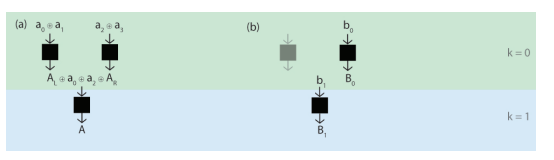

Information Causality identifies the strongest quantum correlations. The possible no-signaling correlations satisfying Information Causality can be precisely identified using the depicted scheme. Alice receives $N = 2^n$ input bits and correspondingly Bob receives n input bits $b_n$ which describe the index of the bit he is interested in,
b =
Pn−1
k=0 bk2
k
. She is allowed to send a single bit, m = 1.
In the case of n = 2, to encode information about her data,
Alice uses a pyramid of NS-boxes as shown in the panel (a).
Note that Fig. 2 shows how Bob can correctly guess the first
or second bit of Alice using a single pair of the boxes (the case
of n = 1). If Alice has more bits, then they recursively use
this protocol in the following way. E. g., for four input bits
of Alice, two pairs of NS-boxes on the level k = 0 allow Bob
to make the guess of a value of any one of Alice’s bits as soon
as he knows either a0 ⊕ AL or a2 ⊕ AR, where AL (AR) is the
output of her left (right) box on the level k = 0, which are
the one-bit messages of the protocol in Fig. 2. These can be
encoded using the third box, on the level k = 1, by inserting
their sum to the Alice’s box and sending x = a0 ⊕ AL ⊕ A
to Bob (A is the output of her box on the level k = 1). Depending on the bit he is interested in, he now reads a suitable
message using the box on the level k = 1 and uses one of the
boxes on the level k = 0. An example of situation in which
Bob aims at the value of a2 or a3 is depicted in the panel (b).
Bob’s final answer is x ⊕ B0 ⊕ B1, where Bk is the output of
his box on the kth level. Generally, Alice and Bob use a pyramid of N −1 pairs of boxes placed on n levels. Looking at the
binary decomposition of b Bob aims (n − r) times at the left
bit and r times at the right, where r = b0+...+bn−1. His final
guess is the sum of β = x ⊕ B0 ⊕ ... ⊕ Bn−1. Therefore, Bob’s
final guess is correct whenever he has made an even number
of errors in the intermediate steps. This leads to Eq. (8) for
the probability of his correct final guess (see Supplementary
Information for the details of this calculation).

Bob’s answer is computed as the sum of the message $x$ and suitable outputs of $n$ boxes. Whenever an even number of boxes produce “wrong” outputs, i.e. such that $A \oplus B \neq ab$, Bob still arrives at the correct final answer. Therefore, Bob’s guess is correct whenever he has made an even number of errors in the intermediate steps.

Let us denote by

$$
Q^{(k)}_{\mathrm{even}}(P)
=
\sum_{j=0}^{\lfloor k/2 \rfloor}
\binom{k}{2j}
P^{k-2j}
(1 - P)^{2j}
=
\frac{1}{2}\left[1 + (2P - 1)^k\right]
\tag{20}
$$

the probability to make an even number of errors when using $k$ pairs of boxes, each producing a correct value with probability $P$.

Similarly, the probability to make an odd number of errors reads

$$
Q^{(k)}_{\mathrm{odd}}(P)
=
\sum_{j=0}^{\lfloor (k-1)/2 \rfloor}
\binom{k}{2j + 1}
P^{k-2j-1}
(1 - P)^{2j+1}
=
\frac{1}{2}\left[1 - (2P - 1)^k\right].
\tag{21}
$$

With this notation, the probability that Bob’s final guess of the value of $a_K$ is correct is given by

$$
P_K
=
Q^{(n-k)}_{\mathrm{even}}(P_I)\, Q^{(k)}_{\mathrm{even}}(P_{II})
+
Q^{(n-k)}_{\mathrm{odd}}(P_I)\, Q^{(k)}_{\mathrm{odd}}(P_{II})
=
\frac{1}{2}\left[1 + E_I^{n-k} E_{II}^k\right],
\tag{22}
$$

with $E_j = 2P_j - 1$.

We are now ready to compute the Information Causality quantity (1) of the main text:

$$
I
=
\sum_{K=1}^{N} \left[1 - h(P_K)\right]
=
\sum_{k=0}^{n}
\binom{n}{k}
\left[
1 - h\left(
\frac{1 + E_I^{n-k} E_{II}^k}{2}
\right)
\right]
$$

and we obtain the bound

$$
I
\ge
\frac{1}{2 \ln 2}
\sum_{k=0}^{n}
\binom{n}{k}
(E_I^2)^{n-k}
(E_{II}^2)^k.
$$

It is also possible, and not difficult, to show that whenever EI and EII do not violate Information Causality then there exists a quantum protocol that gives such correlations.

For the isotropic correlations (6) of the main  $E_I =E_{II} = E$, hence eq. (22) becomes 
$$
P_K = \frac{1}{2}[1 + E^n] 
$$



In [4]:
import math
from pathlib import Path
import imageio.v3 as iio
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import sys
import pandas as pd


# Generate frames for field sizes 2**n (n = 2..39 step 2) and assemble into an MP4
frames_dir = Path("movie_frames")
frames_dir.mkdir(exist_ok=True)

p_high_values_movie = [n / 100 for n in range(75, 100, 1)]
noise_level_movie = 0.0
m_movie = 1
interp_factor = 5  # 5x more frames via interpolation (no extra QSB calls)


def ic_limit_large_n2_movie(n2: int, m: int, channel_noise: float) -> float:
    """IC limit p for very large n2 using asymptotic approx when r is tiny."""
    def H_bin(x: float) -> float:
        if x <= 0.0 or x >= 1.0:
            return 0.0
        return -x * math.log2(x) - (1.0 - x) * math.log2(1.0 - x)

    cap = 1.0 - H_bin(channel_noise)
    m_eff = m * cap
    if m_eff <= 0.0:
        return 0.5

    r = m_eff / float(n2)
 
    delta = math.sqrt(r * math.log(2.0) / 2.0)
    return 0.5 + delta


def compute_curve(field_size: int):
    """Compute ref_log curve and ic line for a single field size."""
    results_list = []
    n2 = field_size * field_size
    exponent = int(math.log2(n2))

    for p_high in p_high_values_movie:
        base = 2.0 * p_high - 1.0
        ref_log = float("-inf") if base <= 0.0 else -1.0 + exponent * math.log2(base)

        ic_bound = ic_limit_large_n2_movie(n2=n2, m=m_movie, channel_noise=noise_level_movie)
        eps = ic_bound - 0.5
        ic_log_local = math.log2(eps) if eps > 0.0 else float("-inf")

        results_list.append({
            "player_type": f"assisted / p_high={p_high:.2f}",
            "field_size": field_size,
            "noise_level": noise_level_movie,
            "reference_log2": ref_log,
            "information_constraint_log2": ic_log_local,
        })

    results_df_local = pd.DataFrame(results_list)
    p_high_arr_local = np.array(p_high_values_movie, dtype=float)
    ref_log_vals_local = results_df_local["reference_log2"].to_numpy()
    ic_log_line_local = float(results_df_local["information_constraint_log2"].iloc[0])

    return {
        "field_size": field_size,
        "p_high_arr": p_high_arr_local,
        "ref_log_vals": ref_log_vals_local,
        "ic_log_line": ic_log_line_local,
    }


def plot_curve_to_file(p_high_arr, ref_log_vals, ic_log_line, field_size_label: str, out_path: Path):
    p_high_marker = (1 + np.sqrt(2) / 2) / 2

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(p_high_arr, ref_log_vals, marker="o", linewidth=2, label="ref_log")
    ax.axhline(ic_log_line, linestyle="--", color="gray", linewidth=1.5, label="Shannon")
    ax.axvline(p_high_marker, linestyle="--", color="red", linewidth=1.5, label="Tsirelson")

    ax.set_xlabel("Box quality (P)", fontsize=12)
    ax.set_ylabel("Win rate (log scale: -1 for Pwin = 100%, -infinity for Pwin = 50%)", fontsize=12)
    ax.set_title(f"Win rate (log) vs Box quality (P) for field size: {field_size_label}", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.75, 1.0)

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    x_pad = 0.01 * (x_max - x_min)
    y_pad = 0.01 * (y_max - y_min)

    ax.text(x_min + x_pad, ic_log_line + y_pad, "Shannon",
            ha="left", va="bottom", fontsize=12, color="gray")
    ax.text(p_high_marker + x_pad, y_max - y_pad, "Tsirelson",
            rotation=90, ha="left", va="top", fontsize=12, color="red")

    # Freeze y-ticks to xx.y format
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    fig.tight_layout()
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close(fig)


# Precompute curves for all field sizes (one QSB pass per size)
field_sizes = [2 ** n for n in range(2, 40, 2)]
curves = [compute_curve(fs) for fs in field_sizes]

# Interpolate between consecutive curves to make 5x frames without extra QSB calls
frame_paths = []
frame_idx = 0
for idx in range(len(curves) - 1):
    c0 = curves[idx]
    c1 = curves[idx + 1]

    for step in range(interp_factor):
        alpha = step / float(interp_factor)
        ref_interp = (1 - alpha) * c0["ref_log_vals"] + alpha * c1["ref_log_vals"]
        ic_interp = (1 - alpha) * c0["ic_log_line"] + alpha * c1["ic_log_line"]
        fs_label = f"~{int(round((1 - alpha) * c0['field_size'] + alpha * c1['field_size']))}"
        frame_path = frames_dir / f"frame_{frame_idx:03d}.png"
        plot_curve_to_file(c0["p_high_arr"], ref_interp, ic_interp, fs_label, frame_path)
        frame_paths.append(frame_path)
        frame_idx += 1

# Add the final true curve as the last frame
last_curve = curves[-1]
final_path = frames_dir / f"frame_{frame_idx:03d}.png"
plot_curve_to_file(
    last_curve["p_high_arr"],
    last_curve["ref_log_vals"],
    last_curve["ic_log_line"],
    str(last_curve["field_size"]),
    final_path,
)
frame_paths.append(final_path)

# Assemble frames into an MP4 (requires imageio-ffmpeg)
frames = [iio.imread(p) for p in frame_paths]
video_path = Path("field_size_sweep.mp4")
iio.imwrite(video_path, frames, fps=2, codec="libx264")
print(f"Saved {len(frames)} frames to {frames_dir} and video to {video_path}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1182, 880) to (1184, 880) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved 91 frames to movie_frames and video to field_size_sweep.mp4


In [14]:
import math
from pathlib import Path
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np

# --- SETTINGS (match your notebook) ---
frames_dir = Path("movie_frames")
frames_dir.mkdir(exist_ok=True)

noise_level = 0.0
m = 1

p_arr = np.array([n/100 for n in range(75, 100, 1)], dtype=float)
y_shape = np.log2(2.0 * p_arr - 1.0)

p_marker = (1 + np.sqrt(2) / 2) / 2  # your Tsirelson marker stays identical

# Smooth k sweep (use k=4..76 if your video is 2^2..2^38)
k_values = np.linspace(4, 100, 500)  # more frames = smoother
y_arr = -1 + k_values[0] * y_shape
# --- CREATE FIGURE ONCE (same styling as your current plot_curve_to_file) ---
fig, ax = plt.subplots(figsize=(8, 6))
(line,) = ax.plot(p_arr, y_arr, marker="o", linewidth=2, label="ref_log")
ic_hline = ax.axhline(-10, linestyle="--", color="gray", linewidth=1.5, label="Shannon")
ax.axvline(p_marker, linestyle="--", color="red", linewidth=1.5, label="Tsirelson")

ax.set_xlabel("Box quality (P)", fontsize=12)
ax.set_ylabel("Win rate (log scale) \n -1 for Pwin = 100%, -infinity for Pwin = 50%", fontsize=12)
title = ax.set_title("", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc="best", fontsize=10)

# Choose fixed y-limits so the video doesn't “jump” due to autoscale
ax.set_xlim(p_arr.min(), p_arr.max())
ax.set_ylim(y_arr.min(), y_arr.max())  # adjust to your preferred window
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
def frame_label_from_k(k: float) -> str:
    # Field size n = 2^(k/2)
    n = 2 ** (k / 2.0)
    return f"~ {int(round(n))} × {int(round(n))}"

frame_paths = []
for idx, k in enumerate(k_values):
    # Update curve (same shape, scaled/shifted)
    ref_log_vals = -1.0 + k * y_shape
    line.set_ydata(ref_log_vals)
    ax.set_ylim(ref_log_vals.min(), ref_log_vals.max())  # adjust to your preferred window
    # Update IC line
    n2 = int(round(2.0 ** k))
    ic_bound = ic_limit_large_n2_movie(n2=n2, m=m, channel_noise=noise_level)
    eps = ic_bound - 0.5
    ic_log_line = math.log2(eps) if eps > 0 else -np.inf
    ic_hline.set_ydata([ic_log_line, ic_log_line])

    # Update title
    title.set_text(f"Win rate (log) vs Box quality (P) \n Field size: {frame_label_from_k(k)}")

    # Save frame
    out_path = frames_dir / f"frame_{idx:04d}.png"
    fig.savefig(out_path, dpi=150)
    frame_paths.append(out_path)

plt.close(fig)

# Assemble mp4
video_path = Path("qseabattle_large_field_limit.mp4")
frames = [iio.imread(p) for p in frame_paths]
iio.imwrite(video_path, frames, fps=30)
print("Saved:", video_path)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 900) to (1200, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved: qseabattle_smooth.mp4
